In [ ]:
# -*- coding: utf-8 -*-
# Regression Example With Boston Dataset: Standardized and Wider
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers
from sklearn.utils import shuffle

import pandas as pd
import seaborn as sns
import keras
import keras.utils
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np


from cgi import test



In [115]:
dataset = pd.read_csv('aggregated_data-tmp.csv')
dataset = shuffle(dataset)

std_scaler = StandardScaler()

train_dataset = dataset.sample(frac=0.8, random_state=3)
test_dataset = dataset.drop(train_dataset.index)


train_features = train_dataset.copy()
test_features = test_dataset.copy()


train_labels = train_features.pop('Concentration')
test_labels = test_features.pop('Concentration')

train_features = std_scaler.fit_transform(train_features.to_numpy())
dict = {'Time':train_features[:, 0], 'Current':train_features[:, 1], 'Spin Coating':train_features[:, 2] ,'Increaing PPM':train_features[:, 3], 'Temperature':train_features[:, 4], 'Repeat Sensor Use':train_features[:, 5], 'Days Elapsed':train_features[:, 6]}
train_features = pd.DataFrame(dict)

test_features = std_scaler.fit_transform(test_features.to_numpy())
dict = {'Time':test_features[:, 0], 'Current':test_features[:, 1], 'Spin Coating':test_features[:, 2] ,'Increaing PPM':test_features[:, 3], 'Temperature':test_features[:, 4], 'Repeat Sensor Use':test_features[:, 5], 'Days Elapsed':test_features[:, 6]}
test_features = pd.DataFrame(dict)

#For later use
data_labels = dataset.pop('Concentration')

In [ ]:

#sns.pairplot(train_dataset[['Time','Current', 'Spin Coating', 'Increasing PPM', 'Temperature', 'Repeat Sensor Use', 'Days Elapsed', 'Concentration']], diag_kind='kde')

#train_dataset = std_scaler.fit_transform(train_dataset.to_numpy())
#dict = {'Time':train_dataset[:, 0],'Current':train_dataset[:, 1], 'Spin Coating':train_dataset[:, 2] ,'Increasing PPM':train_dataset[:, 3], 'Temperature':train_dataset[:, 4], 'Repeat Sensor Use':train_dataset[:, 5], 'Days Elapsed':train_dataset[:, 6], 'Concentration':train_dataset[:, 7] }
#train_dataset = pd.DataFrame(dict)

#test_dataset = std_scaler.transform(test_dataset)
#dict2 = {'Time':test_dataset[:, 0],'Current':test_dataset[:, 1], 'Spin Coating':test_dataset[:, 2] ,'Increasing PPM':test_dataset[:, 3], 'Temperature':test_dataset[:, 4], 'Repeat Sensor Use':test_dataset[:, 5], 'Days Elapsed':test_dataset[:, 6], 'Concentration':test_dataset[:, 7] }
#test_dataset = pd.DataFrame(dict2)

In [ ]:
#Iterate through this a few dozen times

def build_model(n1, n2):
  #Experiment with different models, thicknesses, layers, activation functions; Don't limit to only 10 nodes; Measure up to 64 nodes in 2 layers
  model = keras.Sequential([
    layers.Dense(n1, activation=tf.nn.relu, input_shape=[len(train_features.keys())]),
    layers.Dense(n2, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

  return model

def model_history(features, labels, model, epo, batch, vbs):
  
    history = model.fit(
        features, labels,
        epochs=epo, batch_size=batch, validation_split=0.2, verbose=vbs #, callbacks=early_stop
    )

    hist = pd.DataFrame(history.history)
    
    return hist



In [ ]:


def plot_loss(history):

  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  plt.show()

def correlation_plots(model, label, input_data, title, xlabel, ylabel):
#test_loss, test_acc = model.evaluate(test_features, test_labels, verbose = 1)

  test_predictions = model.predict(input_data).flatten()
  plt.scatter(label,test_predictions)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.axis('equal')
  plt.axis('square')
  plt.grid(True)
  plt.show()
  return test_predictions


def plotGraph(y_test, y_pred,regressorName):
    plt.scatter(range(len(y_pred)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    plt.show()
    return




In [ ]:
def KCrossValidation(i, features, labels, num_val_samples, epochs, batch, verbose, n1, n2):

    print('processing fold #', i)
    val_data = features[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([features[:i * num_val_samples], features[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([labels[:i * num_val_samples], labels[(i + 1) * num_val_samples:]],     axis=0)

    model = build_model(n1, n2)

    history = model_history(partial_train_data, partial_train_targets, model, epochs, batch, verbose)

    test_loss, test_mae, test_mse = model.evaluate(val_data, val_targets, verbose=1)

    return model, history, test_loss, test_mae, test_mse

import numpy as np
k_folds = 4
num_val_samples = len(train_labels) // k_folds

sum_nodes = 65
num_epochs = 100
batch_size = 100
verbose = 0
avg_val_scores = []
order_of_architecture = []

all_networks  = []
all_history  = []
mae_history = []



#(TAKEN FROM DEEP LEARNING WITH PYTHON BY MANNING)
for i in range(32, sum_nodes):

    for j in range(32, sum_nodes):
        if (i+j > sum_nodes):
            continue
        
        print("first hidden layer", i)
        print("second hidden layer", j)
        k_fold_test_scores = []
        k_models = []
        k_history = []

        k_mae_history = []

        for fold in range(k_folds):
            model, history, test_loss, test_mae, test_mse = KCrossValidation(
                fold, 
                train_features, 
                train_labels, 
                num_val_samples, 
                num_epochs, 
                batch_size, 
                verbose, 
                j, 
                i)

            plot_loss(history)
            k_fold_test_scores.append(test_mae)
            k_history.append(history)
            k_models.append(model)
            k_mae_history.append(history['val_mae'])


        avg_val_scores.append(sum(k_fold_test_scores)/len(k_fold_test_scores))
        all_history.append(k_history)
        all_networks.append(k_models)

        
        mae_history.append([ np.mean([x[i] for x in k_mae_history]) for i in range(num_epochs)])


        order_of_architecture.append([i, j])


        test_predictions = correlation_plots(model, test_labels, test_features, "Testing Correlation Plot", "Actual", "Predicted")
        plotGraph(test_labels, test_predictions, "Testing Plot")


        training_predictions = correlation_plots(model, train_labels, train_features, "Training Correlation Plot", "Actual", "Predicted")
        #plotGraph(train_labels, training_predictions, "Training Plot")




In [ ]:
def smooth_curve(points, factor=0.5):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Find the model with the lowest error
k_folds = 4
lowest_index = avg_val_scores.index(min(avg_val_scores))
optimal_NNs = all_networks[lowest_index]

#print(mae_history)
# Find the history of that model, and display it
for i in range(k_folds):
    x = all_history[lowest_index][i]['val_mae']

   # print(x)
plt.plot(range(1, len(mae_history[lowest_index][5:]) + 1), mae_history[lowest_index][5:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

smooth_mae_history = smooth_curve(mae_history[lowest_index][5:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [ ]:
def scaleDataset(data):
    data = std_scaler.fit_transform(data.to_numpy())
    dict = {'Time':data[:, 0], 'Current':data[:, 1], 'Spin Coating':data[:, 2] ,'Increaing PPM':data[:, 3], 'Temperature':data[:, 4], 'Repeat Sensor Use':data[:, 5], 'Days Elapsed':data[:, 6]}
    return pd.DataFrame(dict)


def isolateParams(column, val_array):
    index = [np.where(dataset[column].to_numpy()  == val_array)]

    dataset = scaleDataset(dataset)

    features = [dataset.iloc[val_array]]

    label = [data_labels.to_numpy()[val_array]]


In [ ]:

# Split the data labels with spin coating 0 and 1
sc_index = [np.where(dataset['Spin Coating'].to_numpy()  == 0)[0], np.where(dataset['Spin Coating'].to_numpy()  == 1)[0]]

dataset = scaleDataset(dataset)

#The full features of the data points that use Spin Coating
sc_features = [dataset.iloc[sc_index[0]], dataset.iloc[sc_index[1]]]

#The stupid labels for Spin coating vs. not Spin coating
sc_label = [data_labels.to_numpy()[sc_index[0]], data_labels.to_numpy()[sc_index[1]]]

sc_mae = []
for i in range(0, 2):
    tmp_mae = []
    for NN in optimal_NNs:
        test_loss, test_mae, test_mse = NN.evaluate(sc_features[i], sc_label[i],batch_size=10,  verbose=1)
        tmp_mae.append(test_mae)

        sc_predictions = correlation_plots(NN, sc_label[i], sc_features[i], "Testing Correlation Plot for SC " + str(i), "Actual", "Predicted")
        plotGraph(sc_label[i], sc_predictions, "SC Plot")

    sc_mae.append(tmp_mae)
    


print(sc_mae)
#train_labels = train_features.pop('Concentration')
#test_labels = test_features.pop('Concentration')

# Split the data labels according to time
# CREATE 3D MODELS OF THE VARIOUS PARAMETERS

13/13 [==============================] - 0s 3ms/step - loss: 2.4209 - mae: 0.8345 - mse: 2.3698
TIME =  0 S
4/4 [==============================] - 0s 3ms/step


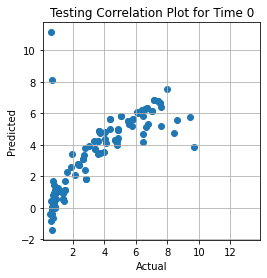

13/13 [==============================] - 0s 3ms/step - loss: 2.3880 - mae: 1.1984 - mse: 2.3864
TIME =  0 S
4/4 [==============================] - 0s 3ms/step


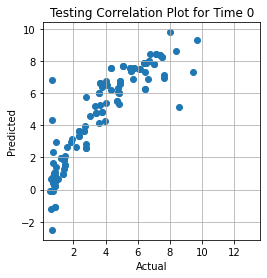

13/13 [==============================] - 0s 3ms/step - loss: 2.5379 - mae: 1.2013 - mse: 2.5274
TIME =  0 S
4/4 [==============================] - 0s 3ms/step


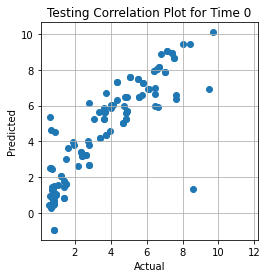

13/13 [==============================] - 0s 2ms/step - loss: 2.4879 - mae: 1.0337 - mse: 2.4552
TIME =  0 S
4/4 [==============================] - 0s 0s/step


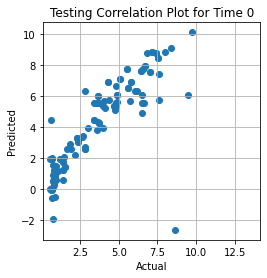

13/13 [==============================] - 0s 2ms/step - loss: 1.1306 - mae: 0.7299 - mse: 1.1466
TIME =  1 S
4/4 [==============================] - 0s 0s/step


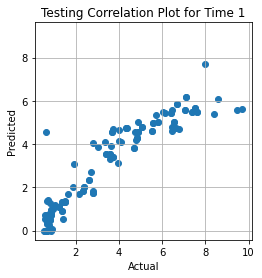

13/13 [==============================] - 0s 2ms/step - loss: 0.8622 - mae: 0.6968 - mse: 0.9002
TIME =  1 S
4/4 [==============================] - 0s 0s/step


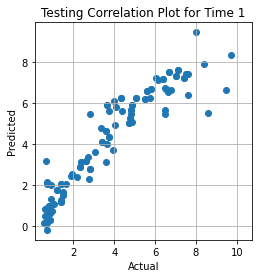

13/13 [==============================] - 0s 2ms/step - loss: 1.3595 - mae: 0.7602 - mse: 1.6625
TIME =  1 S
4/4 [==============================] - 0s 3ms/step


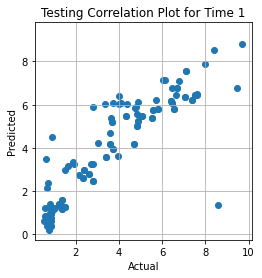

13/13 [==============================] - 0s 3ms/step - loss: 1.5894 - mae: 0.6889 - mse: 2.1848
TIME =  1 S
4/4 [==============================] - 0s 3ms/step


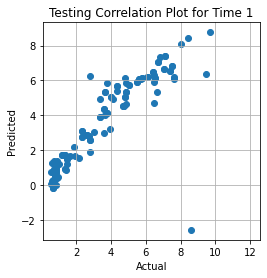

13/13 [==============================] - 0s 3ms/step - loss: 0.9899 - mae: 0.6508 - mse: 0.9724
TIME =  2 S
4/4 [==============================] - 0s 3ms/step


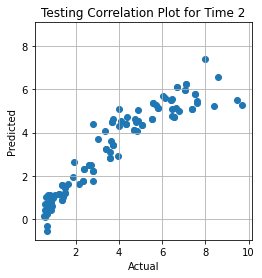

13/13 [==============================] - 0s 2ms/step - loss: 0.7715 - mae: 0.6377 - mse: 0.7699
TIME =  2 S
4/4 [==============================] - 0s 0s/step


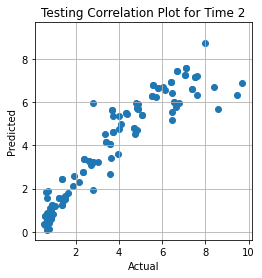

13/13 [==============================] - 0s 2ms/step - loss: 1.2005 - mae: 0.6537 - mse: 1.1917
TIME =  2 S
4/4 [==============================] - 0s 3ms/step


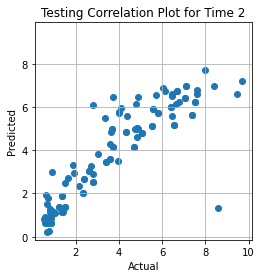

13/13 [==============================] - 0s 2ms/step - loss: 1.5768 - mae: 0.6224 - mse: 1.5348
TIME =  2 S
4/4 [==============================] - 0s 3ms/step


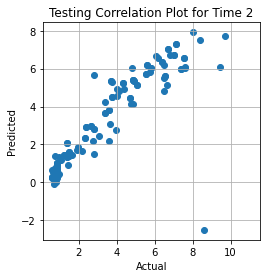

13/13 [==============================] - 0s 2ms/step - loss: 0.8674 - mae: 0.5955 - mse: 0.8733
TIME =  3 S
4/4 [==============================] - 0s 3ms/step


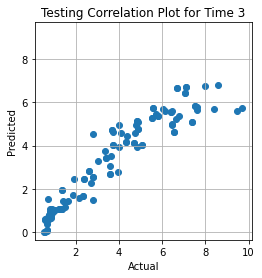

13/13 [==============================] - 0s 1ms/step - loss: 0.8169 - mae: 0.6282 - mse: 0.8176
TIME =  3 S
4/4 [==============================] - 0s 3ms/step


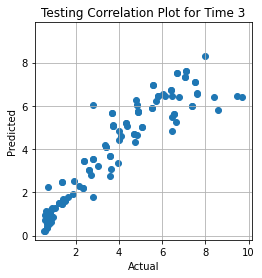

13/13 [==============================] - 0s 2ms/step - loss: 1.1500 - mae: 0.6379 - mse: 1.1283
TIME =  3 S
4/4 [==============================] - 0s 0s/step


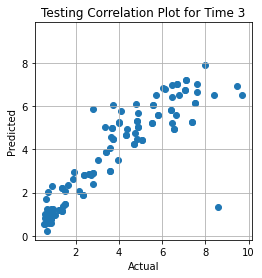

13/13 [==============================] - 0s 2ms/step - loss: 1.6837 - mae: 0.6920 - mse: 1.6669
TIME =  3 S
4/4 [==============================] - 0s 3ms/step


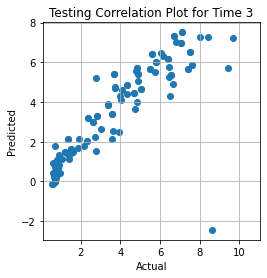

13/13 [==============================] - 0s 2ms/step - loss: 0.7995 - mae: 0.5592 - mse: 0.7784
TIME =  4 S
4/4 [==============================] - 0s 0s/step


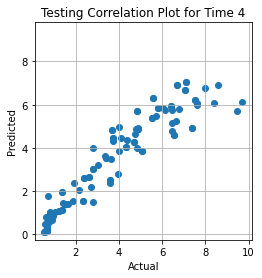

13/13 [==============================] - 0s 2ms/step - loss: 0.7673 - mae: 0.6022 - mse: 0.7504
TIME =  4 S
4/4 [==============================] - 0s 3ms/step


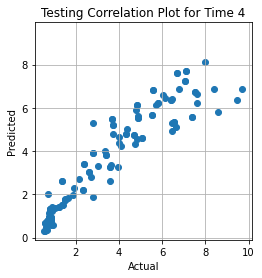

13/13 [==============================] - 0s 2ms/step - loss: 1.1694 - mae: 0.6497 - mse: 1.1397
TIME =  4 S
4/4 [==============================] - 0s 4ms/step


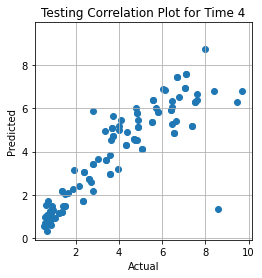

KeyboardInterrupt: 

In [118]:
# Split the data labels with time
time_index= []
for i in range(0, 51):
    time_index.append(np.where(dataset['Time'].to_numpy()  == i)[0])


dataset = scaleDataset(dataset)
#The full features of the data points that use certain time values
time_features = []
for i in range(0, 51):
    time_features.append(dataset.iloc[time_index[i]])

#The stupid labels for each second
time_labels = []
for i in range(0, 51):
    time_labels.append(data_labels.to_numpy()[time_index[i]])


sc_mae = []
for i in range(0, 51):
    tmp_mae = []
    for NN in optimal_NNs:
        test_loss, test_mae, test_mse = NN.evaluate(time_features[i], time_labels[i], batch_size=10,  verbose=1)
        tmp_mae.append(test_mae)

        print("TIME = ", i, "S")
        time_predictions = correlation_plots(NN, time_labels[i], time_features[i], "Testing Correlation Plot for Time " + str(i), "Actual", "Predicted")
        #plotGraph(time_labels[i], time_predictions, "Time Plot")

    sc_mae.append(tmp_mae)
    

# CREATE 3D MODELS OF THE VARIOUS PARAMETERS

In [117]:
shared_index = []

for i in range(0, 51):
    shared_index.append([
        np.where(dataset['Time'].to_numpy()  == i) and np.where(dataset['Spin Coating'].to_numpy()  == 0),
        np.where(dataset['Time'].to_numpy()  == i) and np.where(dataset['Spin Coating'].to_numpy()  ==  1)
        ])



#dataset = scaleDataset(dataset)

shared_features = []
for i in range(0, 51):
    shared_features.append([dataset.iloc[shared_index[i][0]], dataset.iloc[shared_index[i][1]]])

print(shared_features[i][0])
print(shared_features[i][1])

shared_labels = []
for i in range(0, 51):
    shared_labels.append([data_labels.to_numpy()[shared_index[i][0]], data_labels.to_numpy()[shared_index[i][1]]])



shared_mae = []
for i in range(0, 51):
    sc_tmp_mae = []

    for j in range(0, 2):
        tmp_mae = []

#        for NN in optimal_NNs:
            #test_loss, test_mae, test_mse = NN.evaluate(shared_features[i][j], shared_labels[i][j], batch_size=10,  verbose=1)
            #tmp_mae.append(test_mae)

            #print("TIME = ", i, "S")
            #print("SPINCOATED = ", j)
            #shared_predictions = correlation_plots(NN, shared_labels[i][j], shared_features[i][j].to_numpy(),  "Testing Correlation Plot for Shared " + str(j) + "at time: " + str(i), "Actual", "Predicted")
            #plotGraph(shared_labels[i][j], shared_predictions, "Shared Plot")

        #sc_tmp_mae.append(tmp_mae)
#    shared_mae.append(sc_tmp_mae)

       Time  Current  Spin Coating  Increasing PPM  Temperature  \
22433  11.7   -2.990             0               0         22.0   
1647    5.3   -7.350             0               1         22.0   
4914   15.8   -0.261             0               1         22.0   
20223   4.6   -3.820             0               1         22.0   
10595  34.1   -0.156             0               1         22.0   
...     ...      ...           ...             ...          ...   
33389  47.0   -0.135             0               1         22.0   
24895  19.6   -0.214             0               1         22.0   
4209   13.5   -0.295             0               1         22.0   
20738   6.2   -4.330             0               1         22.0   
25799  22.5   -1.420             0               1         22.0   

       Repeat Sensor Use  Days Elapsed  
22433                  0            27  
1647                   0            27  
4914                   0            27  
20223                  0       